# This notebook creates Figure 3

In [48]:
import xarray as xr
import numpy as np
import xcdat as xc
import xskillscore as xscore
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
# import cmocean as cmo
from scipy.stats import linregress
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from typing import Tuple

from matplotlib.gridspec import GridSpec

In [16]:
def get_triangle(tos, latmin: float = -38.75, latmax: float = -1.25, lonmin: float = -178.75, lonmax: float = -71.25, RES: float = 2.5):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    # print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ctos = tos.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))
    nmodel, _, nlon, ntime = ctos.shape
    # print(ctos)

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == nlon: break

        # print("j prior: ", j)
        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
             
        # print("j: ", j)
        nlats = int(len(latcoords) - j) # nlats below diag
        # print("nlats: ", nlats)
        ctos[:,:nlats,i,:] = np.full((nmodel, nlats,ntime), np.nan) 
        
        jold = j
    
    return ctos

In [17]:
def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

SEB_CMIP6 = xr.open_dataset("data/piControl/SEB_CMIP6_full.nc")
SEB_CMIP5 = xr.open_dataset("data/piControl/SEB_CMIP5_full.nc")
shared_models_cmip6 = SEB_CMIP6.model.values
shared_models_cmip5 = SEB_CMIP5.model.values
print(SEB_CMIP6)

ERA = "CMIP6"
U10_CMIP6 = xr.open_dataarray(f"data/piControl/rolling_gradient_U10_{ERA}.nc")
V10_CMIP6 = xr.open_dataarray(f"data/piControl/rolling_gradient_V10_{ERA}.nc")
 
U10_CMIP6 = fix_coords(U10_CMIP6.rename("U10").to_dataset())
V10_CMIP6 = fix_coords(V10_CMIP6.rename("V10").to_dataset())
print(V10_CMIP6)

<xarray.Dataset>
Dimensions:    (model: 35, lat: 72, lon: 144, time: 120, bnds: 2)
Coordinates:
  * model      (model) object 'GISS-E2-1-G' 'EC-Earth3-LR' ... 'CMCC-CM2-SR5'
  * lat        (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 112 113 114 115 116 117 118 119
Dimensions without coordinates: bnds
Data variables: (12/19)
    NET        (model, time, lat, lon) float64 ...
    O          (model, time, lat, lon) float64 ...
    W          (model, time, lat, lon) float64 ...
    RH         (model, time, lat, lon) float64 ...
    DT         (model, time, lat, lon) float64 ...
    LH_Other   (model, time, lat, lon) float64 ...
    ...         ...
    LW_Other   (model, time, lat, lon) float64 ...
    SW_Other   (model, time, lat, lon) float64 ...
    EIS        (model, time, lat, lon) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    lat_b

In [18]:
# Load Rolling Gradient for Regions TOS CMIP6
SST_T_EPSA_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificSA_trend.nc").sel(model=shared_models_cmip6)
SST_T_WE_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_WE-Trend.nc").sel(model=shared_models_cmip6)
SST_T_E_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacific_trend.nc").sel(model=shared_models_cmip6)
SST_T_SO_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_southernOcean_trend.nc").sel(model=shared_models_cmip6)
SST_T_EPT_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc").sel(model=shared_models_cmip6)

# Load Rolling Gradient for Regions TOS CMIP5
SST_T_EPSA_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificSA_trend.nc").sel(model=shared_models_cmip5)
SST_T_WE_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_WE-Trend.nc").sel(model=shared_models_cmip5)
SST_T_E_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacific_trend.nc").sel(model=shared_models_cmip5)
SST_T_SO_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_southernOcean_trend.nc").sel(model=shared_models_cmip5)
SST_T_EPT_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc").sel(model=shared_models_cmip5)

In [29]:
def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)
    
SWCF_CMIP6 = xr.open_dataarray("data/piControl/swcf_east_sa_cmip6_v3.nc")
SWCF_CMIP5 = xr.open_dataarray("data/piControl/swcf_east_sa_cmip5_v3.nc")

SWCF_CMIP6, SEB_CMIP6 = get_shared_models(SWCF_CMIP6, SEB_CMIP6)
SWCF_CMIP5, SEB_CMIP5 = get_shared_models(SWCF_CMIP5, SEB_CMIP5)

SEB_CMIP6, SST_T_EPT_CMIP6 = get_shared_models(SEB_CMIP6, SST_T_EPT_CMIP6)
SEB_CMIP5, SST_T_EPT_CMIP5 = get_shared_models(SEB_CMIP5, SST_T_EPT_CMIP5)

U10_CMIP6, SEB_CMIP6 = get_shared_models(U10_CMIP6, SEB_CMIP6)
V10_CMIP6, SEB_CMIP6 = get_shared_models(V10_CMIP6, SEB_CMIP6)

SWCF_CMIP6, SEB_CMIP6 = get_shared_models(SWCF_CMIP6, SEB_CMIP6)
SWCF_CMIP5, SEB_CMIP5 = get_shared_models(SWCF_CMIP5, SEB_CMIP5)

In [30]:
EPT = get_triangle(SEB_CMIP6["NET"])
SEB_CMIP6_EPT = fix_coords(EPT.rename("NET").to_dataset()).spatial.average("NET")["NET"]
SEB_CMIP6_EPT, SST_T_EPT_CMIP6 = get_shared_models(SEB_CMIP6_EPT, SST_T_EPT_CMIP6)

<xarray.Dataset>
Dimensions:    (model: 26, lat: 72, lon: 144, time: 120, bnds: 2)
Coordinates:
  * model      (model) object 'EC-Earth3-Veg' 'BCC-CSM2-MR' ... 'MIROC6'
  * lat        (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 112 113 114 115 116 117 118 119
Dimensions without coordinates: bnds
Data variables: (12/19)
    NET        (model, time, lat, lon) float64 ...
    O          (model, time, lat, lon) float64 ...
    W          (model, time, lat, lon) float64 ...
    RH         (model, time, lat, lon) float64 ...
    DT         (model, time, lat, lon) float64 ...
    LH_Other   (model, time, lat, lon) float64 ...
    ...         ...
    LW_Other   (model, time, lat, lon) float64 ...
    SW_Other   (model, time, lat, lon) float64 ...
    EIS        (model, time, lat, lon) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds  

In [55]:
bottom_half_swcf = SWCF_CMIP6[SWCF_CMIP6 < SWCF_CMIP6.median()]
top_half_swcf =SWCF_CMIP6[SWCF_CMIP6 >= SWCF_CMIP6.median()]

# Select SST_T_EPT_CMIP6 models that are in the bottom half of SWCF_CMIP6 
# sstb = SST_T_EPT_CMIP6.sel(model=bottom_half_swcf.model)
sstb = SEB_CMIP6_EPT.sel(model=bottom_half_swcf.model)
sebb = SEB_CMIP6.sel(model=bottom_half_swcf.model)
u10b = U10_CMIP6.sel(model=bottom_half_swcf.model)
v10b = V10_CMIP6.sel(model=bottom_half_swcf.model)
sebb = sebb.where(sstb <= -sstb.std("time"))
u10b = u10b.where(sstb <= -sstb.std("time"))
v10b = v10b.where(sstb <= -sstb.std("time"))

# sstt = SST_T_EPT_CMIP6.sel(model=top_half_swcf.model)
sstt = SEB_CMIP6_EPT.sel(model=top_half_swcf.model)
sebt = SEB_CMIP6.sel(model=top_half_swcf.model)
u10t = U10_CMIP6.sel(model=top_half_swcf.model)
v10t = V10_CMIP6.sel(model=top_half_swcf.model)
sebt = sebt.where(sstt <= -sstt.std("time"))
u10t = u10t.where(sstt <= -sstt.std("time"))
v10t = v10t.where(sstt <= -sstt.std("time"))

seb_dif = sebt.mean(["time", "model"]) - sebb.mean(["time", "model"])
v10_dif = v10t.mean(["time", "model"]) - v10b.mean(["time", "model"])
u10_dif = u10t.mean(["time", "model"]) - u10b.mean(["time", "model"])

In [101]:
# Figure out a way to run KStest on the two distributions top and bottom half
# # sebb.stack(dis=("model", "time")).isel(dis=slice(0, 1000))
# a = sebt.stack(dis=("model", "time"))["NET"]
# b = sebb.stack(dis=("model", "time")).isel(dis=slice(0, 1000))["NET"]
# from scipy.stats import kstest

# kstest(a.isel(lat=0, lon=0, dis=0), b.isel(lat=0, lon=0, dis=0))

# Figure 3

In [83]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def global_plot(ax, data, lon, lat, cmap, pvalues=None, winds=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1), cbar_label: str = ""):
    # plot map of global data with central longitude 180
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    if winds is not None: 
        # quiver([X, Y], U, V, [C], **kwargs)
        ax.quiver(lon[::3], lat[::3], winds["U10"][::3,::3], winds["V10"][::3,::3], scale=20, transform=ccrs.PlateCarree())

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -45, 45
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    return img

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/matplotlib/contour.py:1455: U

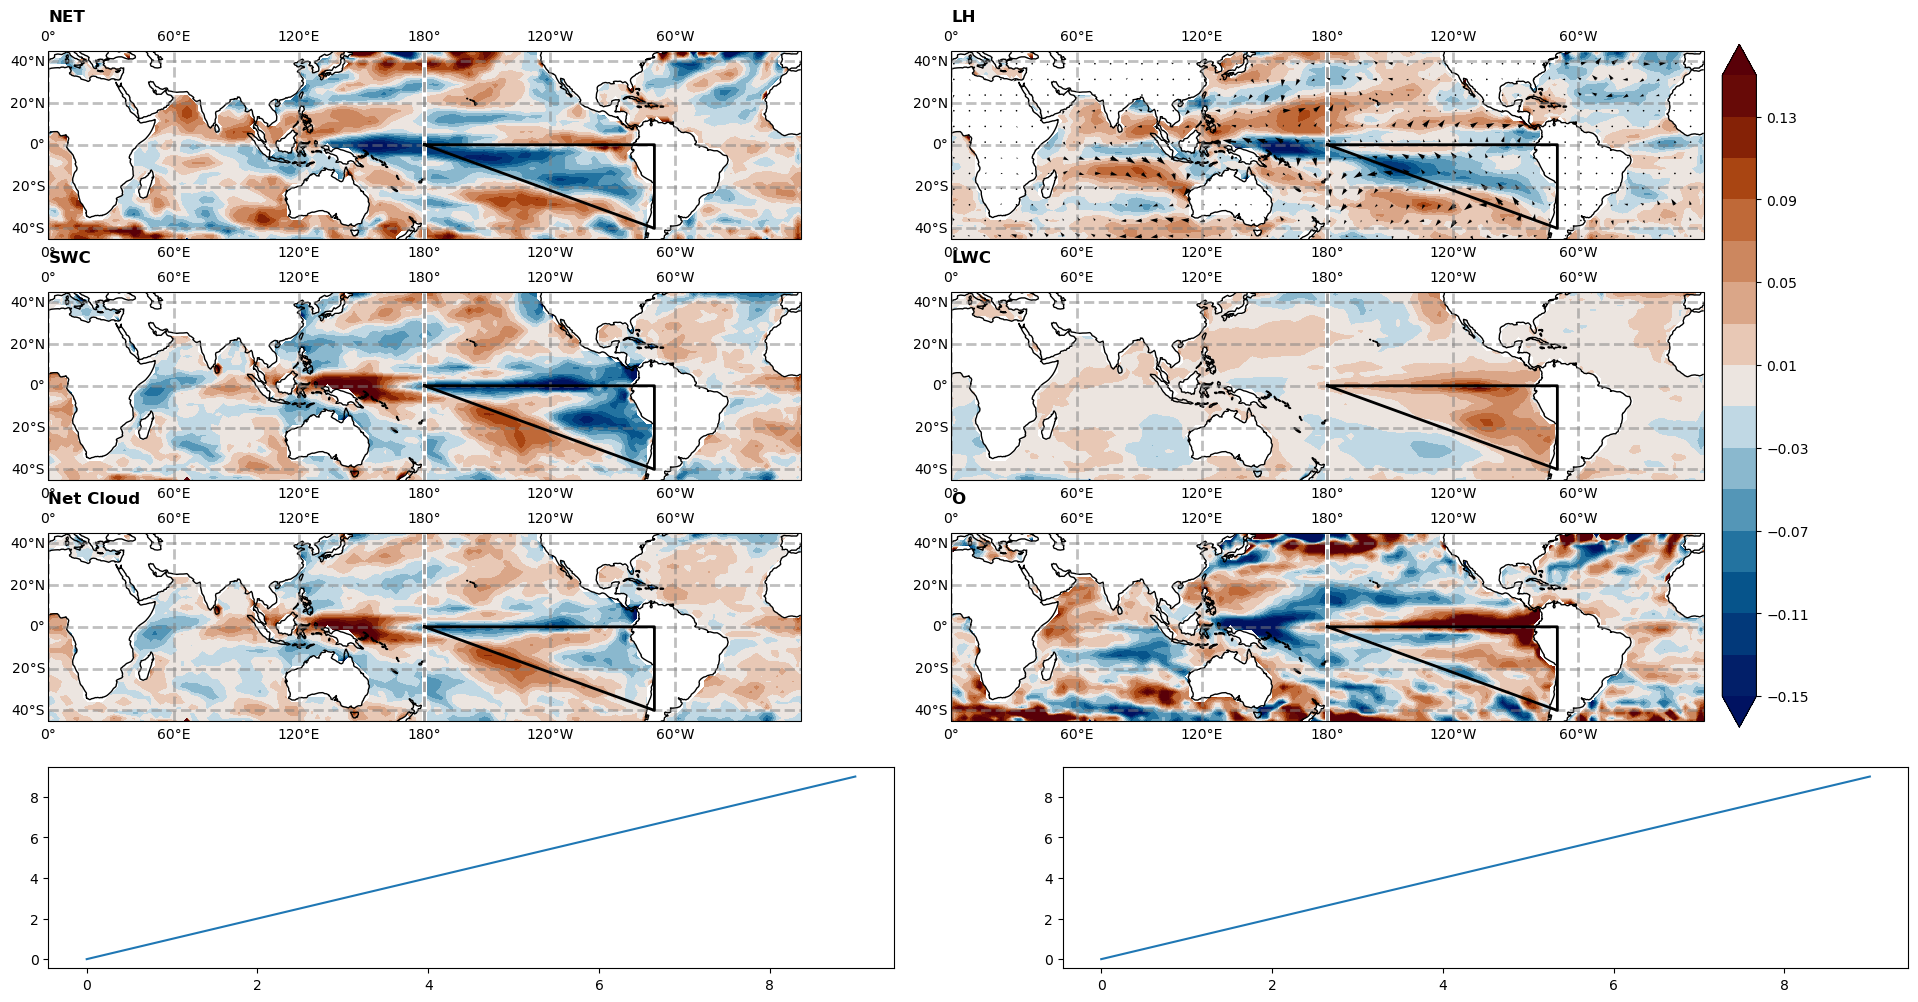

In [87]:
def figure_4(seb_cmip6):
    axis_fontsize = 12
    title_fontsize = 16
    
    fig = plt.figure(figsize=(24,12))
    gs = GridSpec(4, 2)
    ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
    ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=180))
    ax3 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree(central_longitude=180))
    ax4 = fig.add_subplot(gs[3], projection=ccrs.PlateCarree(central_longitude=180))
    ax5 = fig.add_subplot(gs[4], projection=ccrs.PlateCarree(central_longitude=180))
    ax6 = fig.add_subplot(gs[5], projection=ccrs.PlateCarree(central_longitude=180))
    ax7 = fig.add_subplot(gs[6])
    ax8 = fig.add_subplot(gs[7])
    
    trend_min, trend_max, trend_step = -0.15, 0.17, 0.02
    cmap = cmc.vik #"RdBu_r" #cmc.roma_r
    # Plot Figure 4a: SST Trend
    global_plot(
        ax1,
        data=seb_cmip6["NET"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        pvalues=p["NET"].median("model", skipna=True), 
        levels=np.arange(trend_min, trend_max, trend_step),
        cmap=cmap, 
        cbar_label="K/30yr"
    )
    # Plot Figure 4b: Latent Heat Trend
    global_plot(
        ax2,
        data=seb_cmip6["LH_Other"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        pvalues=p["LH_Other"].median("model"), 
        winds={"U10": u10_dif["U10"].to_numpy(), "V10": v10_dif["V10"].to_numpy()},
        levels=np.arange(trend_min, trend_max, trend_step),
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 4c: Shortwave Cloud Trend
    global_plot(
        ax3,
        data=seb_cmip6["SWC"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        pvalues=p["SWC"].median("model"), 
        levels=np.arange(trend_min, trend_max, trend_step),
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 4d: Longwave Cloud Trend
    global_plot(
        ax4,
        data=seb_cmip6["LWC"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        pvalues=p["LWC"].median("model"), 
        levels=np.arange(trend_min, trend_max, trend_step),
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 4e: Cloud Trend
    global_plot(
        ax5,
        data=seb_cmip6["CLOUD"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        pvalues=p["CLOUD"].median("model"), 
        levels=np.arange(trend_min, trend_max, trend_step),
        cmap=cmap, 
        cbar_label="K/30yr"
    )
    
    # Plot Figure 4f: Ocean
    img = global_plot(
        ax6,
        data=seb_cmip6["O"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        pvalues=p["O"].median("model"), 
        levels=np.arange(trend_min, trend_max, trend_step),
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    title_fontsize = 12
    ax1.set_title("NET", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax2.set_title("LH", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax3.set_title("SWC", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax4.set_title("LWC", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax5.set_title("Net Cloud", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax6.set_title("O", loc="left", fontweight="bold", fontsize=title_fontsize)

    fig.colorbar(img, ax=[ax1, ax2, ax3, ax4, ax5, ax6], orientation='vertical', location="right", fraction=.1, pad=0.01)
    
    ax7.plot(np.arange(10), np.arange(10)) 
    ax8.plot(np.arange(10), np.arange(10)) 

    plt.show()

    # Reduce White Space
    # plt.savefig("Figure_4.png", bbox_inches = 'tight')
    
figure_4(seb_dif)